In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn jupyter pyarrow
!pip install sqlalchemy pymysql


In [3]:
import pymysql

# --- connect to MySQL (no database selected yet) ---
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='riya01',  # 🔒 change this
    autocommit=True
)

cursor = conn.cursor()

# --- SQL script for schema and tables ---
sql_script = """
CREATE DATABASE IF NOT EXISTS telecom_db;
USE telecom_db;

DROP TABLE IF EXISTS customers;
CREATE TABLE customers (
  customer_id INT PRIMARY KEY,
  name VARCHAR(60),
  plan_type VARCHAR(20),
  region VARCHAR(30)
);

DROP TABLE IF EXISTS usage_data;
CREATE TABLE usage_data (
  customer_id INT,
  data_used_gb FLOAT,
  calls_made INT,
  revenue_inr FLOAT
);

DROP TABLE IF EXISTS complaints;
CREATE TABLE complaints (
  customer_id INT,
  category VARCHAR(30),
  created_at DATETIME,
  status VARCHAR(20)
);

DROP TABLE IF EXISTS billing;
CREATE TABLE billing (
  customer_id INT,
  tenure INT,
  contract_type VARCHAR(30),
  monthly_charges FLOAT,
  churn VARCHAR(3)
);
"""

# --- execute each statement ---
for statement in sql_script.split(';'):
    if statement.strip():
        cursor.execute(statement)

print("✅ Database and tables created successfully!")

cursor.close()
conn.close()


✅ Database and tables created successfully!


In [8]:
import pandas as pd
from pathlib import Path

# Go one level up to reach Inputs folder
RAW = Path("../Inputs")

cust = pd.read_csv(RAW / "customers.csv")
usage = pd.read_csv(RAW / "usage_data.csv")
comp  = pd.read_csv(RAW / "complaints.csv", parse_dates=["created_at"])
bill  = pd.read_csv(RAW / "billing.csv")

print(cust.shape, usage.shape, comp.shape, bill.shape)
cust.head()


(10, 4) (10, 4) (10, 4) (10, 5)


,customer_id,name,plan_type,region
0,1001,Asha Mehta,Prepaid,Delhi
1,1002,Ravi Kumar,Postpaid,Mumbai
2,1003,Sneha Rao,Prepaid,Chennai
3,1004,Manoj Singh,Postpaid,Delhi
4,1005,Divya Jain,Prepaid,Kolkata


In [9]:
for df,name in [(cust,"customers"),(usage,"usage"),(comp,"complaints"),(bill,"billing")]:
    print(name, "nulls:\n", df.isna().sum(), "\n")

customers nulls:
 customer_id    0
name           0
plan_type      0
region         0
dtype: int64 

usage nulls:
 customer_id     0
data_used_gb    0
calls_made      0
revenue_inr     0
dtype: int64 

complaints nulls:
 customer_id    0
category       0
created_at     0
status         0
dtype: int64 

billing nulls:
 customer_id        0
tenure             0
contract_type      0
monthly_charges    0
churn              0
dtype: int64 



In [10]:
# Trim/case normalisation
cust["region"]    = cust["region"].str.title().str.strip()
cust["plan_type"] = cust["plan_type"].str.title().str.strip()

# Fill numeric gaps sensibly
for col in ["data_used_gb","calls_made","revenue_inr"]:
    usage[col] = usage[col].fillna(usage[col].median())

bill["monthly_charges"] = bill["monthly_charges"].fillna(bill["monthly_charges"].median())
bill["tenure"] = bill["tenure"].fillna(bill["tenure"].median())

# Fill complaints fields
comp["status"]   = comp["status"].fillna("Resolved")
comp["category"] = comp["category"].fillna("General")

# Convert churn to 0/1 flag
bill["churn_flag"] = (bill["churn"].str.lower() == "yes").astype(int)

In [11]:
complaint_agg = (comp
   .groupby("customer_id")
   .agg(
       complaints_total = ("category","count"),
       complaints_open  = ("status", lambda s: (s.str.lower()=="open").sum())
   )
   .reset_index()
)
complaint_agg.head()

,customer_id,complaints_total,complaints_open
0,1002,2,2
1,1003,1,1
2,1004,1,1
3,1005,1,0
4,1006,1,0


In [12]:
df = (cust
      .merge(usage, on="customer_id", how="left")
      .merge(complaint_agg, on="customer_id", how="left")
      .merge(bill, on="customer_id", how="left"))

# Fill new NaNs created by left joins
df[["complaints_total","complaints_open"]] = df[["complaints_total","complaints_open"]].fillna(0).astype(int)

# Final sanity checks
print(df.isna().sum())
df.head()

customer_id         0
name                0
plan_type           0
region              0
data_used_gb        0
calls_made          0
revenue_inr         0
complaints_total    0
complaints_open     0
tenure              0
contract_type       0
monthly_charges     0
churn               0
churn_flag          0
dtype: int64


,customer_id,name,plan_type,region,data_used_gb,calls_made,revenue_inr,complaints_total,complaints_open,tenure,contract_type,monthly_charges,churn,churn_flag
0,1001,Asha Mehta,Prepaid,Delhi,5.2,25,180,0,0,12,Month-to-Month,180,Yes,1
1,1002,Ravi Kumar,Postpaid,Mumbai,12.5,40,280,2,2,24,One Year,280,No,0
2,1003,Sneha Rao,Prepaid,Chennai,7.8,32,210,1,1,8,Month-to-Month,210,Yes,1
3,1004,Manoj Singh,Postpaid,Delhi,15.6,55,320,1,1,30,One Year,320,No,0
4,1005,Divya Jain,Prepaid,Kolkata,3.4,18,120,1,0,6,Month-to-Month,120,Yes,1


In [35]:
OUT = Path("../outputs")
OUT.mkdir(exist_ok=True)
df.to_csv(OUT/"telecom_master.csv", index=False)
print("Saved:", OUT/"telecom_master.csv")

OUT = Path(r"C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4\outputs")
OUT.mkdir(parents=True, exist_ok=True)

Saved: ..\outputs\telecom_master.csv


In [43]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
import os

# ✅ Ensure correct working directory
os.chdir(r"C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4")

# ✅ Load dataset using absolute path
df = pd.read_csv("../outputs/telecom_master.csv")

# ✅ Define output folder
OUT = Path(r"C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4\outputs")
OUT.mkdir(parents=True, exist_ok=True)
print("Saving plots to:", OUT.resolve())

# --- Churn rate ---
churn_rate = df["churn_flag"].mean().round(3)
print(f"Churn Rate: {churn_rate}")

# --- Churn by plan ---
sns.barplot(x="plan_type", y="churn_flag", data=df)
plt.title("Churn by Plan")
plt.savefig(str(OUT / "churn_by_plan.png"), dpi=300, bbox_inches="tight")
plt.close()

# --- Churn by region ---
sns.barplot(x="region", y="churn_flag", data=df)
plt.title("Churn by Region")
plt.xticks(rotation=30)
plt.savefig(str(OUT / "churn_by_region.png"), dpi=300, bbox_inches="tight")
plt.close()

# --- Charges vs churn ---
sns.boxplot(x="churn_flag", y="monthly_charges", data=df)
plt.title("Charges vs Churn")
plt.savefig(str(OUT / "charges_vs_churn.png"), dpi=300, bbox_inches="tight")
plt.close()

# --- Correlation heatmap ---
num = df.select_dtypes("number")
sns.heatmap(num.corr(), cmap="vlag", center=0)
plt.title("Numeric Correlation")
plt.savefig(str(OUT / "numeric_correlation.png"), dpi=300, bbox_inches="tight")
plt.close()

print("\n✅ All plots saved successfully at:", OUT.resolve())


Saving plots to: C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4\outputs
Churn Rate: 0.5

✅ All plots saved successfully at: C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4\outputs


In [48]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import joblib, json, matplotlib.pyplot as plt, seaborn as sns

In [49]:
df = pd.read_csv("../outputs/telecom_master.csv")

# Choose simple, strong baseline features
features = [
    "tenure","monthly_charges","data_used_gb","calls_made","revenue_inr",
    "complaints_total","complaints_open",
    "contract_type","plan_type","region"
]
target = "churn_flag"

X = df[features].copy()
y = df[target].copy()

cat_cols = ["contract_type","plan_type","region"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [50]:
pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

logit = Pipeline([
  ("prep", pre),
  ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

tree = Pipeline([
  ("prep", pre),
  ("clf", DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42))
])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

logit.fit(X_train, y_train)
tree.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'monthly_charges',
                                                   'data_used_gb', 'calls_made',
                                                   'revenue_inr',
                                                   'complaints_total',
                                                   'complaints_open']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['contract_type', 'plan_type',
                                                   'region'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                                        random_state=42))])

In [53]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
import numpy as np

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

def evaluate(name, model):
    pred = model.predict(X_test)
    proba = getattr(model, "predict_proba", lambda X: np.c_[1-pred, pred])(X_test)[:,1]
    acc = accuracy_score(y_test, pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average="binary")
    print(f"{name} -> Acc:{acc:.3f}  Prec:{p:.3f}  Rec:{r:.3f}  F1:{f1:.3f}")

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"outputs/{name.lower()}_confusion_matrix.png")
    plt.close()

    return acc, p, r, f1

metrics = {}
for nm, mdl in [("Logistic", logit), ("DecisionTree", tree)]:
    acc, p, r, f1 = evaluate(nm, mdl)
    metrics[nm] = dict(accuracy=acc, precision=p, recall=r, f1=f1)

with open("outputs/model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)


Logistic -> Acc:1.000  Prec:1.000  Rec:1.000  F1:1.000
DecisionTree -> Acc:1.000  Prec:1.000  Rec:1.000  F1:1.000


In [20]:
best = logit if metrics["Logistic"]["f1"] >= metrics["DecisionTree"]["f1"] else tree
joblib.dump(best, "../outputs/model.pkl")
print("Saved best model.")

Saved best model.


In [21]:
best = joblib.load("../outputs/model.pkl")
df_pred = df.copy()
df_pred["churn_prob"] = best.predict_proba(X)[:,1]
df_pred["churn_pred"] = (df_pred["churn_prob"] >= 0.5).astype(int)
df_pred.to_csv("../outputs/predictions.csv", index=False)
print("Saved predictions.csv")

Saved predictions.csv


✅ Data Loaded Successfully!
Customers: (10, 4) | Usage: (10, 4) | Billing: (10, 5) | Complaints: (10, 4)

✅ Data Merged Successfully!
Merged Shape: (11, 14)
💾 Merged dataset saved as C:\Users\riyas\TELECOM_CHURN_CAPSTONE\output1\merged_dataset_v1.csv

✅ Data Cleaning & Encoding Done!

📦 Train-Test Split Done!

🚀 Training Logistic Regression ...
📉 Confusion matrix saved for Logistic Regression

🚀 Training Random Forest ...
📉 Confusion matrix saved for Random Forest

🚀 Training SVM ...
📉 Confusion matrix saved for SVM

🚀 Training XGBoost ...
📉 Confusion matrix saved for XGBoost

📈 Model performance summary saved as C:\Users\riyas\TELECOM_CHURN_CAPSTONE\output1\model_performance_summary_v1.csv
                 Model  Accuracy  Precision  Recall  F1 Score
1        Random Forest  1.000000   1.000000     1.0  1.000000
0  Logistic Regression  0.666667   0.500000     1.0  0.666667
2                  SVM  0.333333   0.333333     1.0  0.500000
3              XGBoost  0.333333   0.333333     1.0 

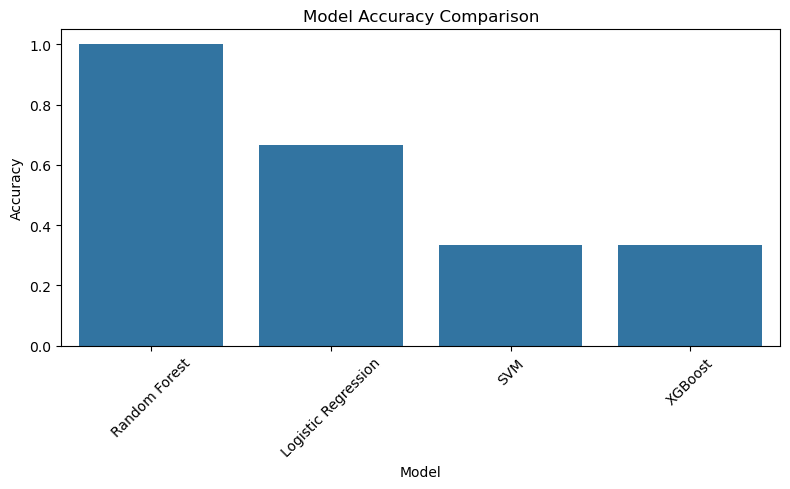


💾 Predictions from best model (Random Forest) saved as C:\Users\riyas\TELECOM_CHURN_CAPSTONE\output1\Random_Forest_predictions_v1.csv

🎯 Pipeline completed successfully! All outputs stored in 'output1' folder — no warnings displayed.


In [25]:
# =============================================================
# 📊 TELECOM CHURN PREDICTION SYSTEM
# Capstone Project - Group 4 (Clean Version by Riya)
# =============================================================

import os
import warnings
warnings.filterwarnings("ignore")   # 🔕 Ignore all warnings for clean output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# --- 1. Define Paths ---
base_path = r"C:\Users\riyas\TELECOM_CHURN_CAPSTONE"
input_path = os.path.join(base_path, "Inputs")
output_path = os.path.join(base_path, "output1")
os.makedirs(output_path, exist_ok=True)

# --- 2. Load Input Datasets ---
customers = pd.read_csv(os.path.join(input_path, "customers.csv"))
usage = pd.read_csv(os.path.join(input_path, "usage_data.csv"))
billing = pd.read_csv(os.path.join(input_path, "billing.csv"))
complaints = pd.read_csv(os.path.join(input_path, "complaints.csv"))

print("✅ Data Loaded Successfully!")
print("Customers:", customers.shape, 
      "| Usage:", usage.shape, 
      "| Billing:", billing.shape, 
      "| Complaints:", complaints.shape)

# --- 3. Merge Datasets ---
df = (
    customers.merge(usage, on="customer_id", how="left")
             .merge(billing, on="customer_id", how="left")
             .merge(complaints, on="customer_id", how="left")
)

print("\n✅ Data Merged Successfully!")
print("Merged Shape:", df.shape)

# Save merged dataset
merged_file = os.path.join(output_path, "merged_dataset_v1.csv")
df.to_csv(merged_file, index=False)
print(f"💾 Merged dataset saved as {merged_file}")

# --- 4. Handle Missing Values (No chained assignment) ---
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

# --- 5. Encode Categorical Data ---
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    if col != "customer_id":
        df[col] = le.fit_transform(df[col])

print("\n✅ Data Cleaning & Encoding Done!")

# --- 6. Target Column ---
if 'churn' not in df.columns:
    df['churn'] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
    print("\n⚠️ 'churn' column not found — dummy target created for demo.")

# --- 7. Split Features and Target ---
X = df.drop(columns=['customer_id', 'churn'])
y = df['churn']

# --- 8. Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 9. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("\n📦 Train-Test Split Done!")

# --- 10. Model Training ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss', verbosity=0)
}

results = []
predictions = {}

for name, model in models.items():
    print(f"\n🚀 Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([name, acc, prec, rec, f1])
    predictions[name] = y_pred

    # Save each model’s confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual_No", "Actual_Yes"],
                         columns=["Pred_No", "Pred_Yes"])
    cm_df.to_csv(os.path.join(output_path, f"{name.replace(' ', '_')}_confusion_matrix.csv"))
    print(f"📉 Confusion matrix saved for {name}")

# --- 11. Compare Model Performance ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

summary_file = os.path.join(output_path, "model_performance_summary_v1.csv")
results_df.to_csv(summary_file, index=False)
print(f"\n📈 Model performance summary saved as {summary_file}")
print(results_df)

# --- 12. Visualization ---
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "model_accuracy_chart_v1.png"))
plt.show()

# --- 13. Save Best Model Predictions ---
best_model_name = results_df.iloc[0, 0]
best_pred = predictions[best_model_name]
pred_df = pd.DataFrame({
    "Actual_Churn": y_test.values,
    "Predicted_Churn": best_pred
})
pred_file = os.path.join(output_path, f"{best_model_name.replace(' ', '_')}_predictions_v1.csv")
pred_df.to_csv(pred_file, index=False)
print(f"\n💾 Predictions from best model ({best_model_name}) saved as {pred_file}")

print("\n🎯 Pipeline completed successfully! All outputs stored in 'output1' folder — no warnings displayed.")


In [28]:
import os
print(os.getcwd())

C:\Users\riyas\TELECOM_CHURN_CAPSTONE\Capstone_Project_grp4
